In [3]:
import sunpy

In [4]:
sunpy.system_info()

SunPy Installation Information

#######
General
#######
Time : Tuesday, 04. June 2019 07:29PM UT
System : Darwin
Processor : i386
Arch : 64bit
SunPy : 1.0.0
OS: Mac OS X 10.14.4 (i386)


##################
Required Libraries
##################
Python: 3.7.3
NumPy: 1.16.2
SciPy: 1.2.1
matplotlib: 3.0.3
Astropy: 3.1.2
Pandas: 0.24.2
parfive: 0.2.1


#####################
Recommended Libraries
#####################
beautifulsoup: 4.7.1
PyQt4: NOT INSTALLED
PyQt5: 5.9.2
Zeep: 3.3.1
Sqlalchemy: 1.3.1
drms: 0.5.6


In [5]:
import matplotlib.pyplot as plt

import numpy as np

from astropy.time import Time
from astropy.coordinates import get_body_barycentric, SkyCoord
import astropy.units as u

from sunpy.coordinates import get_body_heliographic_stonyhurst
import sunpy.map

In [6]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (16,8)

# SunPy & Coordinates

SunPy coordinates allows us to deal with points in physical space, and the SunPy coordinates subpackage provides definitions of and transformations between several reference frames commonly used in solar physics. This allows us to manipulate Maps and take advantage of WCS Axes for plotting

These reference frames and their associated transformations are implemented using the `astropy.coordinates` subpackage and extend Astropy’s coordinate frame transformation graph to include solar coordinates

In [7]:
from sunpy.net import helioviewer

hv = helioviewer.HelioviewerClient()
f = hv.download_jp2('2014/05/15 07:54', observatory='STEREO_A', instrument='SECCHI', detector='COR2')
cor2 = sunpy.map.Map(f)

SSL error in data received
protocol: <asyncio.sslproto.SSLProtocol object at 0x1c1e222710>
transport: <_SelectorSocketTransport fd=68 read=polling write=<idle, bufsize=0>>
Traceback (most recent call last):
  File "/anaconda3/lib/python3.7/asyncio/sslproto.py", line 526, in data_received
    ssldata, appdata = self._sslpipe.feed_ssldata(data)
  File "/anaconda3/lib/python3.7/asyncio/sslproto.py", line 207, in feed_ssldata
    self._sslobj.unwrap()
  File "/anaconda3/lib/python3.7/ssl.py", line 767, in unwrap
    return self._sslobj.shutdown()
ssl.SSLError: [SSL: KRB5_S_INIT] application data after close notify (_ssl.c:2609)


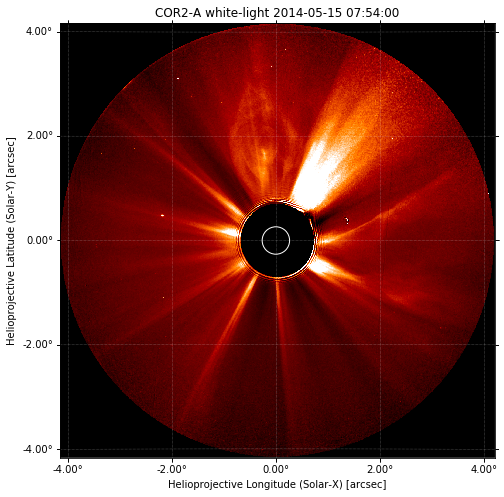

In [8]:
ax = plt.subplot(projection=cor2)
cor2.plot(vmin=0, vmax=600)
cor2.draw_limb()

lon, lat = ax.coords
lon.set_major_formatter('d.dd')
lat.set_major_formatter('d.dd')

This plot is in the coordinate frame with respect to the observer location of the STEREO spacecraft. A number of bright object are also seen from this field of view. Let's see where the planets were at the time this image was taken to see if one of them might be in the field of view.

We have access to where this image was taken from

In [9]:
cor2.observer_coordinate

<SkyCoord (HeliographicStonyhurst: obstime=2014-05-15T07:54:00.005): (lon, lat, radius) in (deg, deg, m)
    (158.18219, 4.9816789, 1.4380171e+11)>

and also the coordinate frame

In [10]:
cor2.coordinate_frame

<Helioprojective Frame (obstime=2014-05-15T07:54:00.005, rsun=695700000.0 m, observer=<HeliographicStonyhurst Coordinate (obstime=2014-05-15T07:54:00.005): (lon, lat, radius) in (deg, deg, m)
    (158.18219, 4.9816789, 1.4380171e+11)>)>

## Position of the planets

In [11]:
# Lets grab the positions of each of the planets in stonyhurt coordinates.
planet_list = ['earth', 'venus', 'mars', 'mercury', 'sun']
planet_coord = [get_body_heliographic_stonyhurst(this_planet, time=cor2.date) for this_planet in planet_list]

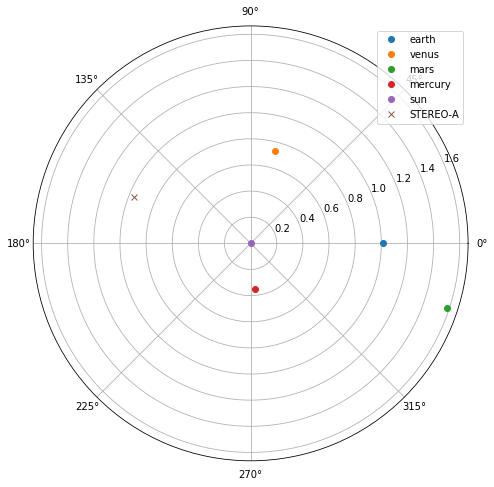

In [12]:
ax = plt.subplot(1, 1, 1, projection='polar')
for this_planet, this_coord in zip(planet_list, planet_coord):
    plt.polar(this_coord.lon.to('rad').value, this_coord.radius, 'o', label=this_planet)
plt.polar(cor2.observer_coordinate.lon.to('rad'), cor2.observer_coordinate.radius.to('au'), 'x', label='STEREO-A')
plt.legend()
plt.show()

It looks like Mars might be in the field of view. Let's check.

In [13]:
# get the location of mars
mars = get_body_heliographic_stonyhurst('mars', cor2.date, observer=cor2.observer_coordinate)
mars_hpc = mars.transform_to(cor2.coordinate_frame)

INFO: Apparent body location accounts for 1269.95 seconds of light travel time [sunpy.coordinates.ephemeris]


In [14]:
mars_hpc

<Helioprojective Coordinate (obstime=2014-05-15T07:54:00.005, rsun=695700000.0 m, observer=<HeliographicStonyhurst Coordinate (obstime=2014-05-15T07:54:00.005): (lon, lat, radius) in (deg, deg, m)
    (158.18219, 4.9816789, 1.4380171e+11)>): (Tx, Ty, distance) in (arcsec, arcsec, km)
    (-7870.72071699, 1713.81711738, 3.80721207e+08)>

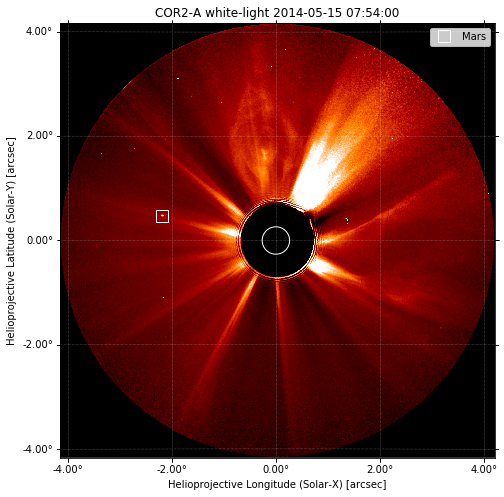

In [15]:
ax = plt.subplot(projection=cor2)
cor2.plot(vmin=0, vmax=600)
cor2.draw_limb()

lon, lat = ax.coords
lon.set_major_formatter('d.dd')
lat.set_major_formatter('d.dd')
ax.plot_coord(mars_hpc, 's', color='white', fillstyle='none', markersize=12, label='Mars')
plt.legend()

## Getting Star fields

In [16]:
from astroquery.vizier import Vizier

In [17]:
###############################################################################
# To efficiently search the star field we need to know what stars are near the
# Sun as observed by STEREO. This can be found by find the difference vector
# between the Sun and the location of STEREO.
stereo = cor2.observer_coordinate.transform_to('icrs').cartesian
sun = get_body_barycentric('sun', time=cor2.date)
diff = sun - stereo
search_coord = SkyCoord(diff, frame='icrs')

In [18]:
vv=Vizier(columns=['**'], row_limit=-1, column_filters={'Gmag':'<7'}, timeout=1200)
vv.ROW_LIMIT = -1
result = vv.query_region(search_coord, radius=4 * u.deg, catalog='I/345/gaia2')

In [19]:
print(len(result[0]))

23


In [20]:
hpc_coords = []
for this_object in result[0]:
    tbl_crds = SkyCoord(this_object['RA_ICRS'] * u.deg, this_object['DE_ICRS'] * u.deg,
                                    1e12 * u.km, frame='icrs', obstime=cor2.date)
    hpc_coords.append(tbl_crds.transform_to(cor2.coordinate_frame))


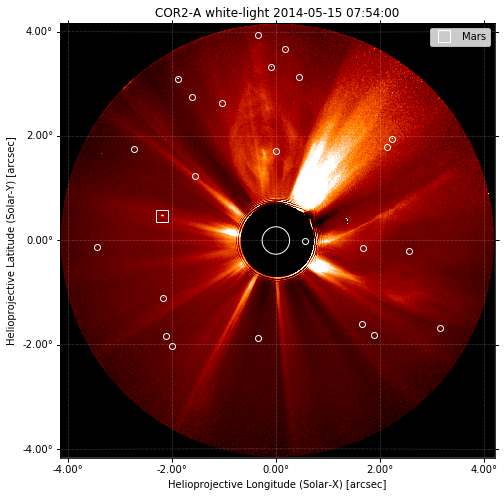

In [21]:
ax = plt.subplot(projection=cor2)
# let's tweak the axis to show in degrees instead of arcsec
lon, lat = ax.coords
lon.set_major_formatter('d.dd')
lat.set_major_formatter('d.dd')
cor2.plot(axes=ax, vmin=0, vmax=600)
cor2.draw_limb()
# plot the mars position
ax.plot_coord(mars_hpc, 's', color='white', fillstyle='none', markersize=12, label='Mars')
# plot all of the stars.
for this_coord in hpc_coords:
    ax.plot_coord(this_coord, 'o', color='white', fillstyle='none')
plt.legend()
plt.show()

## Venus Transit

In [22]:
from astropy.utils.data import download_file
f = download_file('http://jsoc.stanford.edu/data/events/Venus_AIA24s_1600/Out/fits/20120606_040731_UTC.0041.fits')
aiamap = sunpy.map.Map(f)

For this example, we require high precision ephemeris information. The built-in
ephemeris provided by astropy are not accurate enough. This requires jplephem
to be installed.

In [24]:
from astropy.coordinates import solar_system_ephemeris
solar_system_ephemeris.set('jpl')

<ScienceState solar_system_ephemeris: 'jpl'>

In [25]:
venus = get_body_heliographic_stonyhurst('venus', aiamap.date, observer=aiamap.observer_coordinate)
venus_hpc = venus.transform_to(aiamap.coordinate_frame)

INFO: Apparent body location accounts for 144.14 seconds of light travel time [sunpy.coordinates.ephemeris]


## Plotting on Map plots (WCSAxes)

In [26]:
#ax = plt.subplot(111, projection=smap)
print(ax)

WCSAxesSubplot(0.32375,0.125;0.3775x0.755)


In [27]:
fov = 100 * u.arcsec
top_right = SkyCoord(venus_hpc.Tx + fov, venus_hpc.Ty + fov, frame=aiamap.coordinate_frame)
bottom_left = SkyCoord(venus_hpc.Tx - fov, venus_hpc.Ty - fov, frame=aiamap.coordinate_frame)
smap = aiamap.submap(top_right, bottom_left)

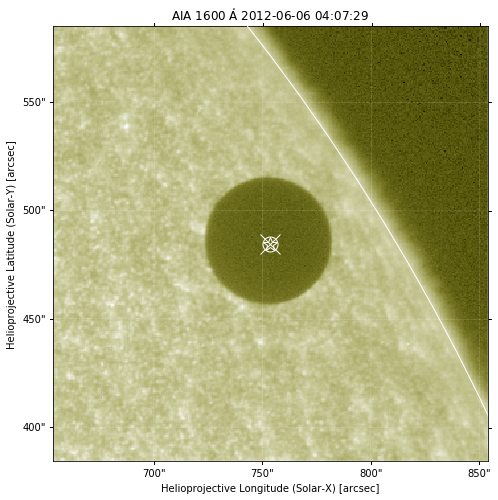

In [28]:
ax = plt.subplot(111, projection=smap)
smap.plot()
smap.draw_limb()

# using the plot_coord command provided by WCSAxes
ax.plot_coord(venus_hpc, 'x', color='white', markersize=20)

# plot in pixel coordinates
ax.plot(smap.world_to_pixel(venus_hpc).x, smap.world_to_pixel(venus_hpc).y, '*', color='white',
        fillstyle='none', markersize=15)

# plot in map coordinates
ax.plot(venus_hpc.Tx.to('deg'), venus_hpc.Ty.to('deg'), 'o', color='white', transform=ax.get_transform('world'),
       fillstyle='none', markersize=15)

plt.show()

# STEREO & SDO loop 
In this example we will see how powerful the coordinates functionality in SunPy is for performing SDO-STEREO data analysis 

Lets first download some AIA and STEREO data

In [74]:
from sunpy.net import Fido, attrs as a


stereo = (a.vso.Source('STEREO_A') &
          a.Instrument('EUVI') &
          a.Time('2010-08-19', '2010-08-19T00:10:00'))

aia = (a.Instrument('AIA') &
       a.vso.Sample(24 * u.hour) &
       a.Time('2010-08-19', '2010-08-19T00:10:00'))

wave = a.Wavelength(17 * u.nm, 18 * u.nm)


res = Fido.search(wave, aia | stereo)

In [76]:
Fido.fetch(res)

['/Users/lahayes/sunpy/data/secchi_l0_a_img_euvi_20100819_20100819_000715_n4eua.fts', '/Users/lahayes/sunpy/data/aia_lev1_171a_2010_08_19t00_00_00_34z_image_lev1.fits']

Now lets make maps for both AIA and EUVI 

In [77]:
map_aia = sunpy.map.Map('aia_lev1_171a_2010_08_19t00_00_00_34z_image_lev1.fits')
map_stereo = sunpy.map.Map('secchi_l0_a_img_euvi_20100819_20100819_000715_n4eua.fts')

Lets get the position of the Sun so that we can plot the positions of AIA and STEREO for comparison

In [95]:
sun_pos = get_body_heliographic_stonyhurst('sun', time = map_aia.date)

Now lets plot the position of STEREO and AIA with respect to the Sun

<SkyCoord (HeliographicStonyhurst: obstime=2010-08-19T00:07:15.007): (lon, lat, radius) in (deg, deg, m)
    (80.28630576, 3.59724222, 1.43992197e+11)>
<SkyCoord (HeliographicStonyhurst: obstime=2010-08-19T00:00:00.340): (lon, lat, radius) in (deg, deg, m)
    (359.98702459, 6.82151148, 1.5139483e+11)>


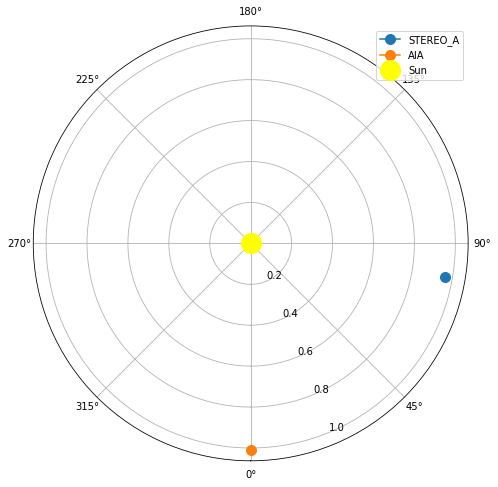

In [97]:
ax = plt.subplot(1,1,1, projection = 'polar')
plt.polar(map_stereo.observer_coordinate.lon.to('rad'), map_stereo.observer_coordinate.radius.to('au'), 
          marker = 'o',  ms = 10, label='STEREO_A')
plt.polar(map_aia.observer_coordinate.lon.to('rad'), map_aia.observer_coordinate.radius.to('au'), 
          marker = 'o', ms = 10, label='AIA')
plt.polar(sun_pos.lon.to('rad').value, sun_pos.radius, 'o',ms =20, label='Sun', color = 'yellow')
ax.set_theta_zero_location("S")
plt.legend()
print(map_stereo.observer_coordinate)
print(map_aia.observer_coordinate)

And plot the two images together

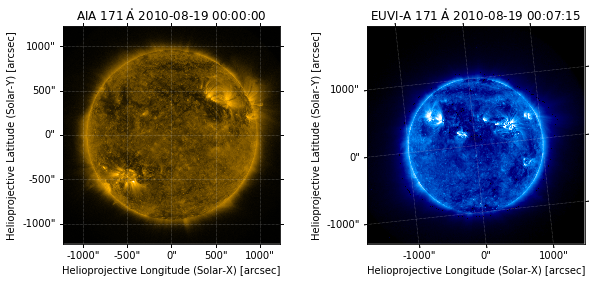

In [98]:
fig = plt.figure(figsize = (10, 4))
ax1 = fig.add_subplot(1,2,1, projection = map_aia)
map_aia.plot(axes = ax1)
ax2 = fig.add_subplot(1,2,2, projection = map_stereo)
map_stereo.plot(axes = ax2)

In [166]:
aia_width = 350 * u.arcsec
aia_height = 320 * u.arcsec
aia_bottom_left = SkyCoord([[350, 300]] * u.arcsec,
                           frame=map_aia.coordinate_frame)
aia_top_right = SkyCoord(aia_bottom_left.Tx + aia_width,
                         aia_bottom_left.Ty + aia_height,
                         frame=map_aia.coordinate_frame)

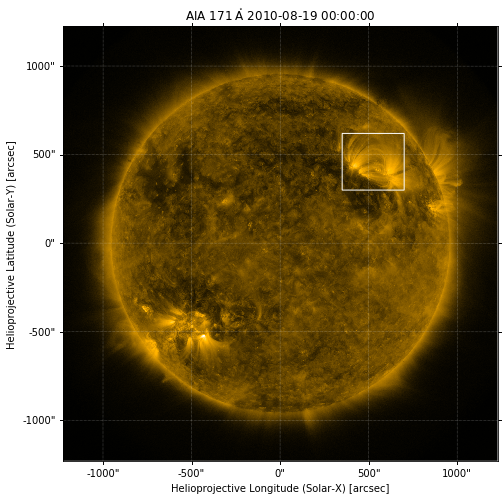

In [171]:
fig = plt.figure()
ax = fig.add_subplot(111, projection=map_aia)
map_aia.plot(axes=ax)
map_aia.draw_rectangle(aia_bottom_left, aia_width, aia_height)

In [172]:
corners = ([aia_bottom_left.Tx, aia_bottom_left.Ty],
           [aia_bottom_left.Tx + aia_width, aia_bottom_left.Ty],
           [aia_bottom_left.Tx, aia_bottom_left.Ty + aia_height],
           [aia_top_right.Tx, aia_top_right.Ty])
hpc_aia = SkyCoord(corners, frame = map_aia.coordinate_frame)
print(hpc_aia)

<SkyCoord (Helioprojective: obstime=2010-08-19T00:00:00.340, rsun=696000000.0 m, observer=<HeliographicStonyhurst Coordinate (obstime=2010-08-19T00:00:00.340): (lon, lat, radius) in (deg, deg, m)
    (359.98702459, 6.82151148, 1.5139483e+11)>): (Tx, Ty) in arcsec
    [[(350., 300.)],
     [(700., 300.)],
     [(350., 620.)],
     [(700., 620.)]]>


Now lets transform these from the frame of AIA to that of EUVI. This transformation takes these coordinates from HPC to HGS and then into the frame of EUVI. 

In [173]:
hpc_B = hpc_aia.transform_to(map_stereo.coordinate_frame)
print(hpc_B)

<SkyCoord (Helioprojective: obstime=2010-08-19T00:07:15.007, rsun=695700000.0 m, observer=<HeliographicStonyhurst Coordinate (obstime=2010-08-19T00:07:15.007): (lon, lat, radius) in (deg, deg, m)
    (80.28630576, 3.59724222, 1.43992197e+11)>): (Tx, Ty, distance) in (arcsec, arcsec, km)
    [[(-757.17259489, 384.27345615, 1.43626201e+08)],
     [(-425.48790044, 332.56870794, 1.43406648e+08)],
     [(-510.37657747, 695.26711147, 1.43641797e+08)],
     [(  33.93492465, 621.53686259, 1.43447856e+08)]]>


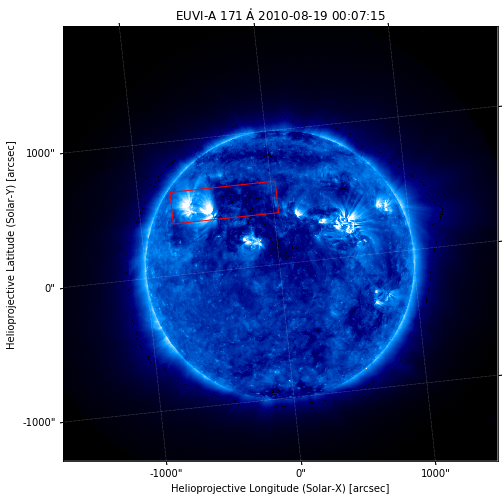

In [174]:
fig = plt.figure()
ax = fig.add_subplot(111, projection=map_stereo)
map_stereo.plot(axes=ax)
w = (hpc_B[3].Tx - hpc_B[0].Tx)
h = (hpc_B[3].Ty - hpc_B[0].Ty)
map_stereo.draw_rectangle(hpc_B[0], w, h,  transform=ax.get_transform('world'), color = 'r')